<a href="https://colab.research.google.com/github/nakulreddy0107/NakulReddy_INFO5731_Spring2025/blob/main/Sarasani_Nakul_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [31]:
import pandas as pd
import re
from collections import defaultdict

def load_dataset(file_path):
    return pd.read_csv(file_path)

def generate_ngrams(text, n):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]

def count_ngrams(text_data, n):
    ngram_counts = defaultdict(int)
    for text in text_data:
        ngrams = generate_ngrams(text, n)
        for ngram in ngrams:
            ngram_counts[ngram] += 1
    return ngram_counts

def calculate_bigram_probabilities(bigram_counts, unigram_counts):
    bigram_probabilities = {}
    for bigram, count in bigram_counts.items():
        w1 = (bigram[0],)
        bigram_probabilities[bigram] = count / unigram_counts[w1]
    return bigram_probabilities

def extract_noun_phrases(text_data):
    noun_phrase_counts = defaultdict(int)
    for text in text_data:
        noun_phrases = re.findall(r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\b', str(text))
        for np in noun_phrases:
            noun_phrase_counts[np.lower()] += 1
    return noun_phrase_counts

def calculate_relative_probabilities(noun_phrase_counts):
    max_np_frequency = max(noun_phrase_counts.values()) if noun_phrase_counts else 1
    return {np: count / max_np_frequency for np, count in noun_phrase_counts.items()}
file_path = "/content/cleaned_papers_20240218.csv"
df = load_dataset(file_path)
text_data = df["cleaned_lemmatized"].dropna().tolist()
bigram_counts = count_ngrams(text_data, 2)
trigram_counts = count_ngrams(text_data, 3)
unigram_counts = count_ngrams(text_data, 1)
bigram_probabilities = calculate_bigram_probabilities(bigram_counts, unigram_counts)
bigram_df = pd.DataFrame(list(bigram_probabilities.items()), columns=["Bigram", "Probability"])
bigram_df.sort_values(by="Probability", ascending=False, inplace=True)
noun_phrase_counts = extract_noun_phrases(text_data)
noun_phrase_probabilities = calculate_relative_probabilities(noun_phrase_counts)
noun_phrases = list(noun_phrase_probabilities.keys())

noun_phrase_matrix = pd.DataFrame(0, index=[f"Review {i+1}" for i in range(min(100, len(text_data)))], columns=noun_phrases)
for idx, text in enumerate(text_data[:100]):
    for np in noun_phrases:
        if np in text.lower():
            noun_phrase_matrix.at[f"Review {idx+1}", np] = noun_phrase_probabilities[np]

def print_table(df, title):
    print(f"\n{title}")
    print(df.head(100).to_string(index=True))

print_table(pd.DataFrame(list(bigram_counts.items()), columns=["Bigram", "Frequency"]), "Bigram Frequencies")
print_table(pd.DataFrame(list(trigram_counts.items()), columns=["Trigram", "Frequency"]), "Trigram Frequencies")
print_table(bigram_df, "Bigram Probabilities")
print_table(noun_phrase_matrix, "Noun Phrase Relative Probabilities")



Bigram Frequencies
                          Bigram  Frequency
0        (present, fashionmnist)          1
1            (fashionmnist, new)          1
2                 (new, dataset)          2
3          (dataset, comprising)          1
4                (comprising, x)          1
5                 (x, grayscale)          1
6             (grayscale, image)          1
7               (image, fashion)          1
8             (fashion, product)          2
9            (product, category)          2
10             (category, image)          1
11                  (image, per)          2
12               (per, category)          1
13          (category, training)          1
14               (training, set)         35
15                  (set, image)          6
16                 (image, test)          1
17                   (test, set)         21
18         (image, fashionmnist)          1
19      (fashionmnist, intended)          1
20             (intended, serve)          2
21          

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [32]:

import pandas as pd
import numpy as np
import math
import re
from collections import Counter

file_path = "/content/cleaned_papers_20240218.csv"
df = pd.read_csv(file_path)
text_column = 'abstract'
if text_column not in df.columns:
    raise ValueError(f"Column '{text_column}' not found in CSV. Available columns: {df.columns}")
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    return text.split()

df['tokens'] = df[text_column].dropna().apply(preprocess)
vocabulary = set(word for tokens in df['tokens'] for word in tokens)
vocab_list = list(vocabulary)
vocab_index = {word: i for i, word in enumerate(vocab_list)}
def compute_tf(tokens):
    term_counts = Counter(tokens)
    total_terms = len(tokens)
    return {word: term_counts[word] / total_terms for word in term_counts}

df['tf'] = df['tokens'].apply(compute_tf)
df_counts = Counter(word for tokens in df['tokens'] for word in set(tokens))
total_docs = len(df)
idf = {word: math.log(total_docs / (df_counts[word] + 1)) for word in vocabulary}
def compute_tfidf(tf):
    return {word: tf[word] * idf[word] for word in tf}

df['tfidf'] = df['tf'].apply(compute_tfidf)
tfidf_matrix = np.zeros((len(df), len(vocab_list)))

for i, tfidf_dict in enumerate(df['tfidf']):
    for word, score in tfidf_dict.items():
        tfidf_matrix[i, vocab_index[word]] = score
query = "An Outstanding movie with a haunting performance and best character development"
query_tokens = preprocess(query)
query_tf = compute_tf(query_tokens)
query_tfidf = np.zeros(len(vocab_list))

for word, score in query_tf.items():
    if word in idf:
        query_tfidf[vocab_index[word]] = score * idf[word]
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2) if norm1 and norm2 else 0
similarities = [cosine_similarity(query_tfidf, tfidf_matrix[i]) for i in range(len(df))]
df['similarity'] = similarities
df_sorted = df.sort_values(by='similarity', ascending=False)
print("\nTop 100 Relevant Documents Based on Query:")
print(df_sorted[[text_column, 'similarity']].head(100))


Top 100 Relevant Documents Based on Query:
                                               abstract  similarity
1092  Matrices of (approximate) low rank are pervasi...    0.194338
19    In this issue, “Best of the Web” presents the ...    0.161421
617   We study the problem of learning to accurately...    0.146705
2749  Named Entity (NE) extraction is an important s...    0.135206
1229  Netflix released a dataset containing 100 mill...    0.127371
...                                                 ...         ...
759   As the demand for data scientists continues to...    0.030284
1497  In order to create a rational planning agent, ...    0.030118
1733  The field of artificial intelligence (AI) has ...    0.029827
604   Applying machine learning to a problem which i...    0.029688
2314  Statistical machine learning techniques, while...    0.029404

[100 rows x 2 columns]


## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


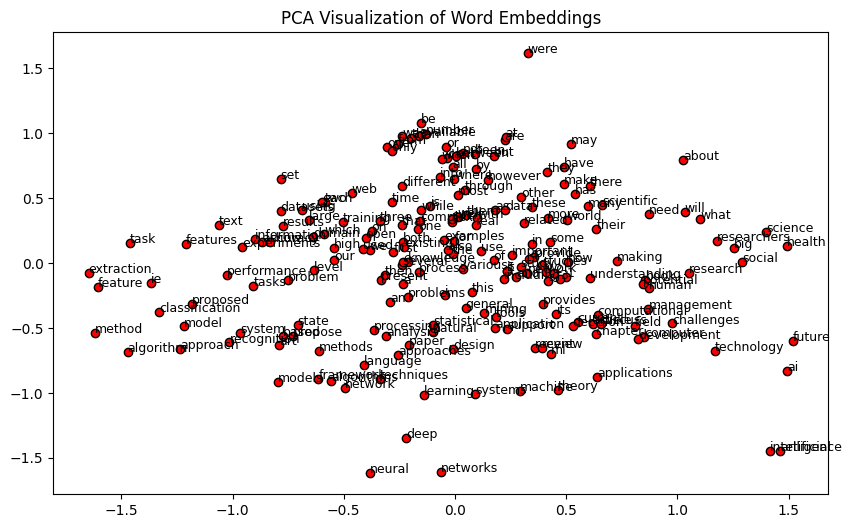

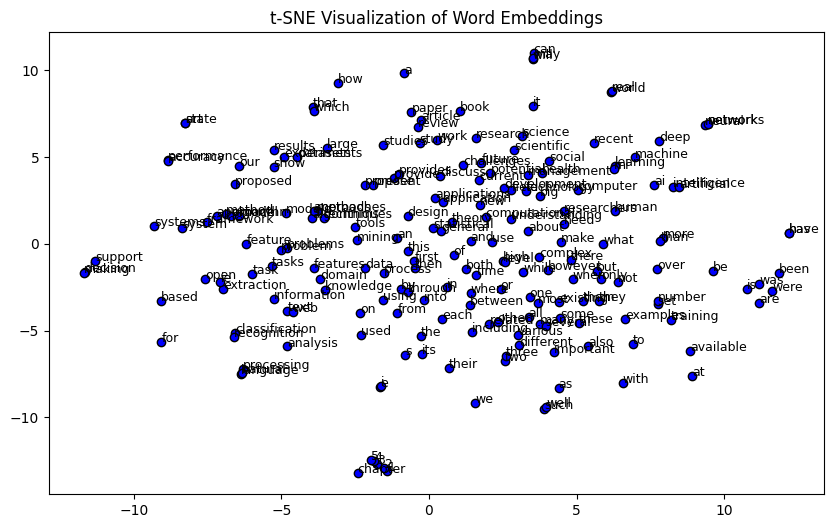

Words king or queen not in vocabulary.
Cosine Similarity (good, bad): 0.6940
Words dog or cat not in vocabulary.
Words car or bus not in vocabulary.


In [17]:
import pandas as pd
import re
import nltk
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
nltk.download('punkt')
file_path = "/content/cleaned_papers_20240218.csv"
df = pd.read_csv(file_path)
text_column = 'abstract'
if text_column not in df.columns:
    raise ValueError(f"Column '{text_column}' not found in CSV. Available columns: {df.columns}")
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    return nltk.word_tokenize(text)

df['tokens'] = df[text_column].dropna().apply(preprocess)
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=300, window=5, min_count=2, workers=4, sg=1)
word2vec_model.save("word2vec_model.bin")
word_vectors = word2vec_model.wv
words = list(word_vectors.index_to_key)[:200]
word_vecs = np.array([word_vectors[word] for word in words])
pca = PCA(n_components=2)
word_vecs_pca = pca.fit_transform(word_vecs)

plt.figure(figsize=(10, 6))
plt.scatter(word_vecs_pca[:, 0], word_vecs_pca[:, 1], edgecolors='k', c='r')
for i, word in enumerate(words):
    plt.annotate(word, (word_vecs_pca[i, 0], word_vecs_pca[i, 1]), fontsize=9)
plt.title("PCA Visualization of Word Embeddings")
plt.show()
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
word_vecs_tsne = tsne.fit_transform(word_vecs)

plt.figure(figsize=(10, 6))
plt.scatter(word_vecs_tsne[:, 0], word_vecs_tsne[:, 1], edgecolors='k', c='b')
for i, word in enumerate(words):
    plt.annotate(word, (word_vecs_tsne[i, 0], word_vecs_tsne[i, 1]), fontsize=9)
plt.title("t-SNE Visualization of Word Embeddings")
plt.show()
def cosine_similarity(word1, word2):
    vec1 = word_vectors[word1]
    vec2 = word_vectors[word2]
    return 1 - cosine(vec1, vec2)
word_pairs = [("king", "queen"), ("good", "bad"), ("dog", "cat"), ("car", "bus")]
for word1, word2 in word_pairs:
    if word1 in word_vectors and word2 in word_vectors:
        print(f"Cosine Similarity ({word1}, {word2}): {cosine_similarity(word1, word2):.4f}")
    else:
        print(f"Words {word1} or {word2} not in vocabulary.")

## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# The GitHub link of your final csv file

# For this dataset, Sentiment Analysis is the chosen NLP task. The goal is to classify research paper abstracts into Positive, Negative, or Neutral categories based on their content.

# Each paper abstract has been assigned one of the following sentiment labels:

# Positive

# Abstracts that describe advancements, benefits, improvements, successful outcomes, efficiency, or breakthroughs.
# Example keywords: improve, benefit, successful, efficient, advance, state-of-the-art, enhance, outperform, novel, breakthrough
# Example:
# "TensorFlow is a machine learning system that operates at large scale and in heterogeneous environments, showing state-of-the-art performance."
# → Labeled as "Positive"

# Negative

# Abstracts that highlight limitations, challenges, problems, inefficiencies, failures, risks, or concerns.
# Example keywords: limitation, challenge, problem, failure, inefficient, drawback, risk, concern, difficulty, ineffective
# Example:
# "Despite the success of the model, it suffers from high computational costs and scalability issues, making it impractical for real-time applications."
# → Labeled as "Negative"

# Neutral

# Abstracts that are purely descriptive or informational without expressing strong positive or negative sentiment.
# Example keywords: General descriptions of datasets, methodologies, or facts without evaluative language.
# Example:
# "We present a dataset containing large-scale graph data for benchmarking machine learning models."
# → Labeled as "Neutral"


# I've uploaded the dataset to the GitHub



# Link: https://github.com/nakulreddy0107/NakulReddy_INFO5731_Spring2025/blob/main/sentiment_analysis_dataset.csv



In [ ]:
# Here is the link to the Collab file

https://colab.research.google.com/drive/1WYiGxKvyk8QWEZt2jQ--vy9xM5ddn9p4?usp=sharing

# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
# The assignment is challenging and interesting and it was difficult to do the assignment from scratch and used few libraries to perform few actions but mostly wrote the code from scratch. Looking forward for more assignments like these which will enhance my skills